In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# mlforecast

> Scalable machine learning based time series forecasting.

**mlforecast** is a framework to perform time series forecasting using machine learning models, with the option to scale to massive amounts of data using remote clusters.

[![CI](https://github.com/Nixtla/mlforecast/actions/workflows/ci.yaml/badge.svg)](https://github.com/Nixtla/mlforecast/actions/workflows/ci.yaml)
[![Python](https://img.shields.io/pypi/pyversions/mlforecast)](https://pypi.org/project/mlforecast/)
[![PyPi](https://img.shields.io/pypi/v/mlforecast?color=blue)](https://pypi.org/project/mlforecast/)
[![conda-forge](https://img.shields.io/conda/vn/conda-forge/mlforecast?color=blue)](https://anaconda.org/conda-forge/mlforecast)
[![License](https://img.shields.io/github/license/Nixtla/mlforecast)](https://github.com/Nixtla/mlforecast/blob/main/LICENSE)

## Install

### PyPI

`pip install mlforecast`

If you want to perform distributed training, you can instead use `pip install mlforecast[distributed]`, which will also install [dask](https://dask.org/). Note that you'll also need to install either [LightGBM](https://github.com/microsoft/LightGBM/tree/master/python-package) or [XGBoost](https://xgboost.readthedocs.io/en/latest/install.html#python).

### conda-forge
`conda install -c conda-forge mlforecast`

Note that this installation comes with the required dependencies for the local interface. If you want to perform distributed training, you must install dask (`conda install -c conda-forge dask`) and either [LightGBM](https://github.com/microsoft/LightGBM/tree/master/python-package) or [XGBoost](https://xgboost.readthedocs.io/en/latest/install.html#python).

## How to use
The following provides a very basic overview, for a more detailed description see the [documentation](https://nixtla.github.io/mlforecast/).

Store your time series in a pandas dataframe in long format, that is, each row represents an observation for a specific serie and timestamp.

In [ ]:
from mlforecast.utils import generate_daily_series

series = generate_daily_series(
    n_series=20,
    max_length=100,
    n_static_features=1,
    static_as_categorical=False,
    with_trend=True
)
series.head()

,ds,y,static_0
unique_id,,,
id_00,2000-01-01,1.751917,72
id_00,2000-01-02,9.196715,72
id_00,2000-01-03,18.577788,72
id_00,2000-01-04,24.520646,72
id_00,2000-01-05,33.418028,72


Next define your models. If you want to use the local interface this can be any regressor that follows the scikit-learn API. For distributed training there are `LGBMForecast` and `XGBForecast`.

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

Now instantiate a `Forecast` object with the models and the features that you want to use. The features can be lags, transformations on the lags and date features. The lag transformations are defined as [numba](http://numba.pydata.org/) *jitted* functions that transform an array, if they have additional arguments you supply a tuple (`transform_func`, `arg1`, `arg2`, ...).

In [ ]:
from mlforecast import Forecast
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

fcst = Forecast(
    models=models,
    freq='D',
    lags=[7, 14],
    lag_transforms={
        1: [expanding_mean],
        7: [(rolling_mean, 7)]
    },
    date_features=['dayofweek'],
    differences=[1],
)

To compute the features and train the models call `fit` on your `Forecast` object. Here you have to specify the columns that:

* Identify each serie (`id_col`). If the series identifier is the index you can specify `id_col='index'`
* Contain the timestamps (`time_col`). Can also be integers if your data doesn't have timestamps.
* Are the series values (`target_col`)

In [ ]:
fcst.fit(series, id_col='index', time_col='ds', target_col='y', static_features=['static_0'])

Forecast(models=[LGBMRegressor, XGBRegressor, RandomForestRegressor], freq=<Day>, lag_features=['lag-7', 'lag-14', 'expanding_mean_lag-1', 'rolling_mean_lag-7_window_size-7'], date_features=['dayofweek'], num_threads=1)

To get the forecasts for the next 14 days call `predict(14)` on the forecast object. This will automatically handle the updates required by the features using a recursive strategy.

In [ ]:
predictions = fcst.predict(14)

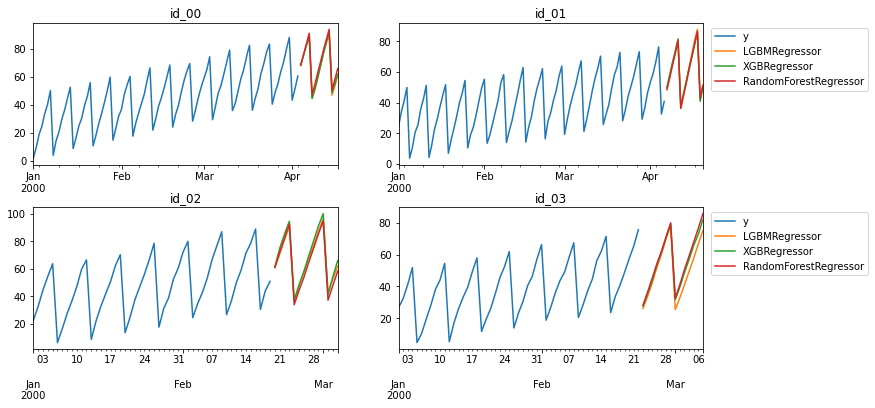

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), gridspec_kw=dict(hspace=0.3))
for i, (cat, axi) in enumerate(zip(series.index.categories, ax.flat)):
    pd.concat([series.loc[cat, ['ds', 'y']], predictions.loc[cat]]).set_index('ds').plot(ax=axi)
    axi.set(title=cat, xlabel=None)
    if i % 2 == 0:
        axi.legend().remove()
    else:
        axi.legend(bbox_to_anchor=(1.01, 1.0))